In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(format='[%(levelname)s] %(asctime)s:\t %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import sys
import os

if f"{os.getcwd()}/../" not in ' '.join(sys.path):
    logging.info('Local module \'almop\' not found in system path. Appending...')
    sys.path.append(f"{os.getcwd()}/../")

[INFO] 2023-04-23 20:50:26,062:	 Local module 'almop' not found in system path. Appending...


In [3]:
#from almop import data as ald
from almop import data as ald
from almop import core as alc
import pandas as pd

In [4]:
hpi_raw = ald.get_hpi(['PL', 'DE', 'IT', 'BE', 'SE'])

In [ ]:
hpi = hpi_raw.copy()
hpi.head()

country,BE,DE,IT,PL,SE
2005-Q1,NaN,NaN,NaN,NaN,NaN
2005-Q2,2.2,-1.8,NaN,NaN,3.3
2005-Q3,3.6,2.1,NaN,NaN,3.9
2005-Q4,2.0,-2.8,NaN,NaN,2.6
2006-Q1,1.9,1.5,NaN,NaN,3.5


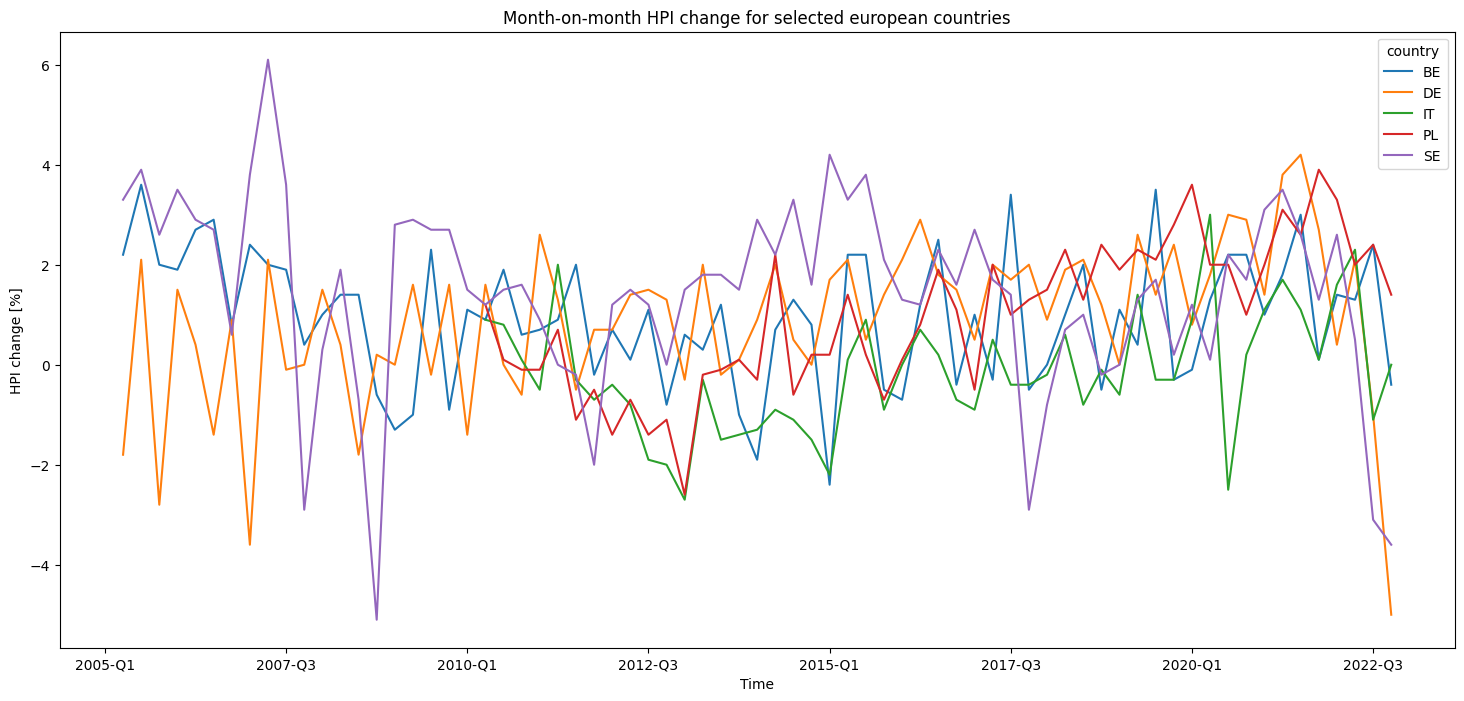

In [6]:
_ = hpi.plot(xlabel='Time', ylabel='HPI change [%]', title='Month-on-month HPI change for selected european countries', figsize=(18, 8), legend=True )

I see the following issues with HPI data loaded above:
1. It's not very granular - quarterly sampling
    * Low observation count per time series
2. Data for **Poland** is missing for a third of the whole time period
    * Will need to either drop data for other countries when not available for **Poland** or backfill for **Poland**